## LSN theoratical toy example
### Quadratic brain ROI trajectories with age

### 1. Additive initial factor: subject variability
### 2. Additive time shift: ROI variability


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import sys

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../")
from src.simul import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
                    


## Brain trajectories
### ROI variability: Additive time shift: ROI variability
### Cortical thickness trajectories can start: 2mm, peak: 3mm, thin: 2.5 ([over lifespan](https://pubmed.ncbi.nlm.nih.gov/24948804/))
### Individual differences (std) ~ 0.1mm with smoothing ([source](https://www.pnas.org/content/pnas/97/20/11050.full.pdf))

In [ ]:
n_timepoints = 100
t = np.arange(n_timepoints)

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(15,10), sharey=False, sharex=False)

func_type_list = ["exp", "poly"]
func_param_list = ["roi_init", "roi_time"]

for f, func_type in enumerate(func_type_list):
    for g, func_param in enumerate(func_param_list):
        if func_type == "exp":
            if func_param == "roi_init":
                func_params1 = {"init_val": 1, "decay": 50}
                func_params2 = {"init_val": 10, "decay": 50}
            else:
                func_params1 = {"init_val": 10, "decay": 10}
                func_params2 = {"init_val": 10, "decay": 80}

        else:
            if func_param == "roi_init":
                func_params1 = {"init_val": 1, "peak_val": 10, "time_shift": 65, "poly_order": 2}
                func_params2 = {"init_val": 9, "peak_val": 10, "time_shift": 65, "poly_order": 2}
            else:
                func_params1 = {"init_val": 1, "peak_val": 10, "time_shift": 50, "poly_order": 2}
                func_params2 = {"init_val": 1, "peak_val": 10, "time_shift": 80, "poly_order": 2}

        traj1 = get_brain_trajectory(n_timepoints,func_type, func_params1)
        traj2 = get_brain_trajectory(n_timepoints,func_type, func_params2)

        ax = axes[f,g]
        ax.plot(t,traj1, label="roi-1")
        ax.plot(t,traj2, label="roi-2")
        ax.set_xlabel("age")
        ax.set_ylabel("thickness")
        ax.legend()
        ax.grid()
        ax.set_title(f"traj_type:{func_type}, roi_variation: {func_param}")

## Generate subject-specific random samples 
### Additive initial factor: subject variability

In [ ]:
# same init factor for each ROI
n_samples = 10
intersubject_std = 0.5

roi_1 = get_traj_samples(traj1, n_samples, intersubject_std)
roi_2 = get_traj_samples(traj2, n_samples, intersubject_std)

palette = 'husl'
sns.set(font_scale=1)

fig, axes = plt.subplots(1,2,figsize=(15,5),sharex=True,sharey=True)
with sns.axes_style("whitegrid"):    
    ax = axes[0]
    g = sns.heatmap(roi_1, ax=ax)
    g.set_xlabel("age")
    g.set_ylabel("sample id")
    g.set_title("ROI-1")
    ax = axes[1]
    g = sns.heatmap(roi_2, ax=ax)
    g.set_title("ROI-2")
    g.set_xlabel("age")

## Extract cross-sectional samples


In [ ]:
roi_list = [roi_1,roi_2]
y_baseline, X_baseline, X_followup = get_cross_sectional_samples(roi_list, followup_interval=10)
fig, axes = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
with sns.axes_style("whitegrid"):    
    ax = axes[0]
    g = sns.heatmap(X_baseline, annot=True, fmt=".3g", ax=ax)
    g.set_xlabel("roi")
    g.set_ylabel("sample id")
    g.set_title("baseline")
    ax = axes[1]
    g = sns.heatmap(X_followup,annot=True, fmt=".3g", ax=ax)
    g.set_title("followup")
    g.set_xlabel("roi")

In [ ]:
time_diff = abs(traj1[1:] - traj1[:-1])
indiv_diff = abs(roi_1[:,0][1:] - roi_1[:,0][:-1])

print(f"time_diff mean: {np.mean(time_diff)}, std: {np.std(time_diff)}")
print(f"indiv_diff mean: {np.mean(indiv_diff)}, std: {np.std(indiv_diff)}")

t_df = pd.DataFrame()
i_df = pd.DataFrame()
t_df["diff"] = time_diff
t_df["type"] = "time"
i_df["diff"] = indiv_diff
i_df["type"] = "indiv"
plot_df = t_df.append(i_df)

sns.histplot(x="diff",bins=100,hue="type",data=plot_df)

## Run entire toy example

In [2]:
# Traj params (Fixed)
traj_func_list = ["exp"] # "poly"
roi_variation_list = ["roi_init"] #, "roi_time"]

subject_variation_list = [0]
followup_list = [2]
n_iterations = 1
data_aug = True
get_flip_perf = True 
swap_only = True

n_timepoints = 100
n_samples_list = [10000]
n_regions_list = [1000]

lr = 0.001
batch_size = 1000
n_epochs = 100
hidden_node_list = [10,50,100]
n_jobs = 4

perf_df = pd.DataFrame()

for it in np.arange(n_iterations):
    for traj_func in traj_func_list:
        for roi_variation in roi_variation_list:            
            for subject_variation in subject_variation_list:
                for followup_interval in followup_list:
                    for n_samples in n_samples_list:
                        for n_regions in n_regions_list: 
                            # Model configs (need to initialized for each data config)
                            model_dict = {
                                "Ridge": Ridge(), 
                                "RF": RandomForestRegressor(n_jobs=n_jobs, random_state=1), 
                                # "GB": GradientBoostingRegressor(random_state=1)
                                "LSN": None,
                            }
                            traj_list = get_trajectories(traj_func, roi_variation, n_timepoints, n_regions)

                            # Get roi samples
                            roi_list = [get_traj_samples(traj, n_samples, subject_variation) for traj in traj_list]

                            # Get cross-sectional time data (sample with replacement)
                            y_baseline, X_baseline, X_followup = get_cross_sectional_samples(roi_list, followup_interval=followup_interval)

                            # normalize y
                            y_followup = y_baseline + followup_interval
                            y_baseline = y_baseline/100
                            y_followup = y_followup/100

                            if followup_interval > 0:                
                                X = np.hstack([X_baseline,X_followup])
                                y = np.vstack([y_baseline,y_followup]).T
                            else:
                                X = X_baseline
                                y = y_baseline
                                
                            # Split for CV and held-out test set
                            n_CV = int(0.75 * len(y))

                            X_CV = X[:n_CV]
                            X_test = X[n_CV:]
                            y_CV = y[:n_CV]
                            y_test = y[n_CV:]

                            if data_aug & (followup_interval > 0) :
                                X_baseline_CV = X_baseline[:n_CV]
                                X_followup_CV = X_followup[:n_CV]
                                y_baseline_CV = y_baseline[:n_CV]
                                y_followup_CV = y_followup[:n_CV]

                                X_CV, y_CV = augment_data(X_baseline_CV, X_followup_CV, y_baseline_CV, y_followup_CV, swap_only=swap_only)

                            if get_flip_perf:
                                if swap_only:                                     
                                    visit_order = list(np.tile(("B,F"),len(y_test))) + list(np.tile(("F,B"),len(y_test)))
                                else:
                                    visit_order = list(np.tile(("B,F"),len(y_test))) + list(np.tile(("F,B"),len(y_test))) \
                                                + list(np.tile(("B,B"),len(y_test))) + list(np.tile(("F,F"),len(y_test)))

                                X_baseline_test = X_test[:,:n_regions]
                                X_followup_test = X_test[:,n_regions:]
                                y_baseline_test = y_test[:,0]
                                y_followup_test = y_test[:,1] 

                                X_test, y_test = augment_data(X_baseline_test, X_followup_test, y_baseline_test, y_followup_test, swap_only=swap_only)                                
                            else:
                                visit_order = list(np.tile(("B,F"),len(y_test)))

                            # Run Models
                            for model_name, model_instance in model_dict.items():
                                print(f"\nSim config: iter: {it}, subject_variation: {subject_variation}, followup: {followup_interval}, \
                                        n_samples: {n_samples}, n_regions= {n_regions}, model: {model_name}, \
                                        traj func type: {traj_func}, shift param: {roi_variation}, data_aug: {data_aug}")

                                if model_name in ["LSN","LSN1","LSN2","LSN3"]:                                            
                                    trained_model_list = []
                                    train_loss_list = []
                                    for hidden_size in hidden_node_list:
                                        if followup_interval > 0:
                                            train_dataset = SimDataset(X_CV[:,:n_regions], X_CV[:,n_regions:], y_CV[:,0], y_CV[:,1])
                                            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                                        
                                            model = LSN(X_baseline.shape[1],hidden_size=hidden_size) # alternative toy model: LSN()
                                            model.train()

                                            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5)                                                                                               
                                            criterion = nn.MSELoss()                        

                                            model, batch_loss_df, epoch_loss_df = train(model,train_dataloader,optimizer,criterion,n_epochs)
                                        else:
                                            train_dataset = SimpleSimDataset(X_CV, y_CV)
                                            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                                        
                                            model = simpleFF(X_CV.shape[1], hidden_size=hidden_size)
                                            model.train()

                                            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5)                                                                                               
                                            criterion = nn.MSELoss()                        

                                            model, batch_loss_df, epoch_loss_df = trainSimpleFF(model,train_dataloader,optimizer,criterion,n_epochs)                            

                                        train_loss = epoch_loss_df["epoch_loss"].values[-1]
                                        train_loss_list.append(train_loss)
                                        trained_model_list.append(model)
                                        
                                    # pick the best model
                                    opt_model_idx = np.argmin(train_loss_list)
                                    train_loss = np.min(train_loss_list)
                                    model = trained_model_list[opt_model_idx]

                                    # test
                                    if followup_interval > 0:                                                                                                                                           
                                        test_dataset = SimDataset(X_test[:,:n_regions], X_test[:,n_regions:], y_test[:,0], y_test[:,1])
                                        test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

                                        model.eval()                    
                                        batch_pred_list, test_MAE1, test_MAE2 = test(model, test_dataloader)
                                        y_pred = np.vstack(np.squeeze(batch_pred_list))
                                        
                                        test_r1 = stats.pearsonr(y_pred[:,0],y_test[:,0])[0]
                                        test_r2 = stats.pearsonr(y_pred[:,1],y_test[:,1])[0]   

                                        test_age_1 = 100*y_test[:,0]
                                        test_age_2 = 100*y_test[:,1]

                                        test_brainage_1 = y_pred[:,0] # for two timepoints y is a matrix
                                        test_brainage_2 = y_pred[:,1]                                    

                                    else:
                                        test_dataset = SimpleSimDataset(X_test, y_test)
                                        test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

                                        model.eval()                    
                                        batch_pred_list, test_MAE1 = testSimpleFF(model, test_dataloader)
                                        y_pred = np.squeeze(np.vstack(batch_pred_list))                                                                        
                                        test_MAE2 = None
                                        
                                        test_r1 = stats.pearsonr(y_pred,y_test)[0]
                                        test_r2 = None

                                        test_age_1 = 100*y_test
                                        test_age_2 = None

                                        test_brainage_1 = y_pred # for single timepoint y is a vector
                                        test_brainage_2 = None

                                else:
                                    CV_scores, y_pred, test_MAE1, test_MAE2, test_r1, test_r2 = get_brain_age_perf(X_CV, y_CV, X_test, y_test, model_instance)
                                    train_loss = np.mean(-1*CV_scores) #negative MSE

                                    if followup_interval > 0:
                                        test_age_1 =100*y_test[:,0]
                                        test_age_2 = 100*y_test[:,1]
                                        test_brainage_1 = y_pred[:,0]
                                        test_brainage_2 = y_pred[:,1]
                                    
                                    else:
                                        test_age_1 = 100*y_test
                                        test_age_2 = None
                                        test_brainage_1 = y_pred
                                        test_brainage_2 = None
                                
                                df = pd.DataFrame()
                                df["eid"] = np.arange(len(y_test))
                                df["test_age_1"] = test_age_1
                                df["test_age_2"] = test_age_2
                                df["test_brainage_1"] = test_brainage_1
                                df["test_brainage_2"] = test_brainage_2
                                df["test_MAE1"] = test_MAE1                    
                                df["test_MAE2"] = test_MAE2
                                df["test_r1"] = test_r1
                                df["test_r2"] = test_r2
                                df["CV_score"] = train_loss
                                df["model"] = model_name
                                df["n_samples"] = n_samples
                                df["n_regions"] = n_regions
                                df["followup_interval"] = followup_interval   
                                df["subject_variation"] = subject_variation
                                df["traj_func"] = traj_func
                                df["roi_variation"] = roi_variation
                                df["data_aug"] = data_aug
                                df["visit_order"] = visit_order
                                df["iter"] = it

                                perf_df = perf_df.append(df)




Sim config: iter: 0, subject_variation: 0, followup: 2,                                         n_samples: 10000, n_regions= 1000, model: Ridge,                                         traj func type: exp, shift param: roi_init, data_aug: True

Sim config: iter: 0, subject_variation: 0, followup: 2,                                         n_samples: 10000, n_regions= 1000, model: RF,                                         traj func type: exp, shift param: roi_init, data_aug: True

Sim config: iter: 0, subject_variation: 0, followup: 2,                                         n_samples: 10000, n_regions= 1000, model: LSN,                                         traj func type: exp, shift param: roi_init, data_aug: True


In [27]:
print(f"perf df shape: {perf_df.shape}, expected: {4*0.25*(it+1)*np.sum(n_samples_list)*len(subject_variation_list)*len(model_dict)*len(n_regions_list)*len(followup_list)}")
perf_df.tail()

perf df shape: (1500, 20), expected: 3000.0


,eid,test_age_1,test_age_2,test_brainage_1,test_brainage_2,test_MAE1,test_MAE2,test_r1,test_r2,CV_score,model,n_samples,n_regions,followup_interval,subject_variation,traj_func,roi_variation,data_aug,flip_perf,iter
495,495,97.0,95.0,0.0,50.578423,97.0,44.421577,NaN,0.782266,0.186097,LSN,1000,100,2,0.5,poly,roi_init,True,1.0,0
496,496,58.0,56.0,0.0,66.077354,58.0,10.077354,NaN,0.782266,0.186097,LSN,1000,100,2,0.5,poly,roi_init,True,1.0,0
497,497,90.0,88.0,0.0,63.012112,90.0,24.987888,NaN,0.782266,0.186097,LSN,1000,100,2,0.5,poly,roi_init,True,1.0,0
498,498,69.0,67.0,0.0,69.211136,69.0,2.211136,NaN,0.782266,0.186097,LSN,1000,100,2,0.5,poly,roi_init,True,1.0,0
499,499,55.0,53.0,0.0,68.738022,55.0,15.738026,NaN,0.782266,0.186097,LSN,1000,100,2,0.5,poly,roi_init,True,1.0,0


## Plot MAE

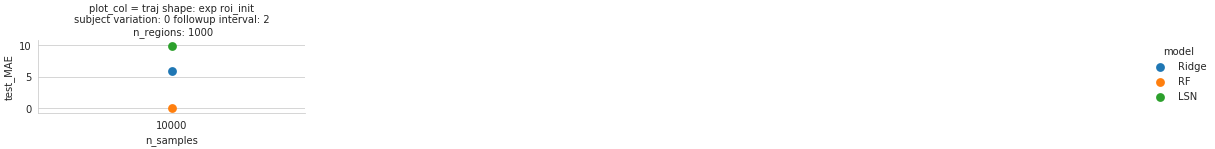

In [3]:
if n_iterations > 1:
    plot_df = perf_df.groupby(["model", "n_samples", "n_regions", "followup_interval", "subject_variation", "iter"]).mean().reset_index().copy()
else:
    plot_df = perf_df.copy()


# func_type = "exp"
# shift_param = "roi_time"
# subject_variation = 0.5
# followup_interval = 2
# plot_df = plot_df[(plot_df["traj_func"]==func_type) & (plot_df["roi_variation"]==shift_param)] 
# plot_df = plot_df[(plot_df["subject_variation"]==subject_variation) & (plot_df["followup_interval"]==followup_interval)]

plot_df["plot_col"] = "traj shape: " + plot_df['traj_func'] + " " + plot_df['roi_variation'] + \
                      "\nsubject variation: " + plot_df['subject_variation'].astype(str) + " " + \
                      "followup interval: " + plot_df['followup_interval'].astype(str) + "\n n_regions: " + plot_df['n_regions'].astype(str)


plot_df["test_MAE"] = 0.5 * (plot_df["test_MAE1"] + plot_df["test_MAE1"])
plot_df["test_r"] = 0.5 * (plot_df["test_r1"] +plot_df["test_r1"])

with sns.axes_style("whitegrid"):
    g = sns.catplot(y="test_MAE",x="n_samples",hue="model",col="plot_col",col_wrap=4, kind="point", data=plot_df, aspect=2, height=2, sharey=False)

## Plot brainage diff

/home/nikhil/projects/green_comp_neuro/green_compute/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


test_MAE  \
traj_func roi_variation model n_regions n_samples visit_order                 
exp       roi_init      LSN   1000      10000     B,F          9.750679e+00   
                                                  F,B          1.001730e+01   
                        RF    1000      10000     B,F          6.487477e-14   
                                                  F,B          6.404183e-14   
                        Ridge 1000      10000     B,F          6.011512e+00   
                                                  F,B          5.928974e+00   

                                                               brainage_diff  \
traj_func roi_variation model n_regions n_samples visit_order                  
exp       roi_init      LSN   1000      10000     B,F              -0.835607   
                                                  F,B              -0.626908   
                        RF    1000      10000     B,F               2.000000   
                                                  F,B              -2.000000   
                        Ridge 1000      10000     B,F               1.531481   
                                                  F,B              -1.531481   

                                                               age_diff  
traj_func roi_variation model n_regions n_samples visit_order            
exp       roi_init      LSN   1000      10000     B,F               2.0  
                                                  F,B              -2.0  
                        RF    1000      10000     B,F               2.0  
                                                  F,B              -2.0  
                        Ridge 1000      10000     B,F               2.0  
                                                  F,B              -2.0

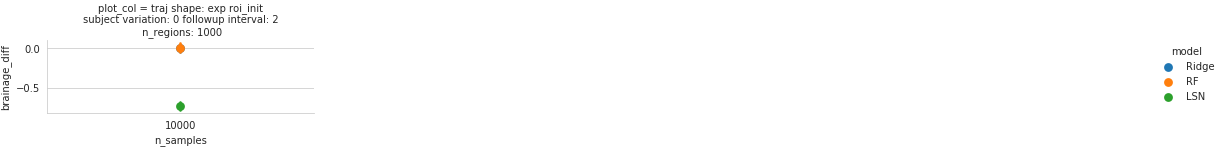

In [4]:
plot_df["age_diff"] = plot_df["test_age_2"] - plot_df["test_age_1"]
plot_df["brainage_diff"] = plot_df["test_brainage_2"] - plot_df["test_brainage_1"]

# print(f"Save string for followup: {followup_interval}")
# print(f"run2_brainage-diff_func_{func_type}_roi-var_{shift_param}_subject-var_{subject_variation}")

with sns.axes_style("whitegrid"):
    g = sns.catplot(y="brainage_diff",x="n_samples",hue="model",col="plot_col",col_wrap=4, kind="point", data=plot_df, aspect=2, height=2, sharey=False)

plot_df.groupby(["traj_func", "roi_variation","model","n_regions","n_samples","visit_order"])["test_MAE","brainage_diff","age_diff"].mean()

,epoch_loss
0,0.328136
1,0.306895
2,0.279074
3,0.259390
4,0.239181
...,...
95,0.022316
96,0.021687
97,0.021078
98,0.020490


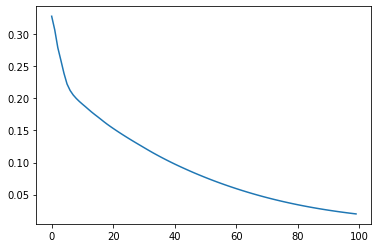

In [5]:
# perf_df.to_csv("results/simulation/brain_diff_sim_twinmodels_data_aug_success_run.csv")
# 
# LSN_df = pd.read_csv("results/simulation/brain_diff_sim_LSN_run_1.csv")
# base_df = pd.read_csv("results/simulation/brain_diff_sim_basemodels_run_2.csv")
# LSN_df = perf_df.copy()

plt.plot(epoch_loss_df)
epoch_loss_df

## Plots

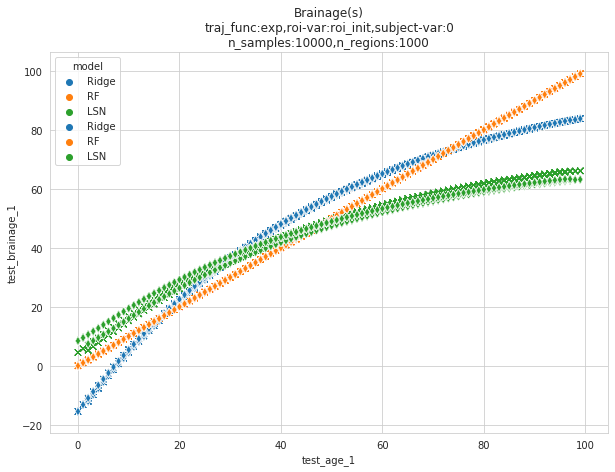

In [6]:
plot_df = perf_df.copy()
func_type = "poly"
shift_param = "roi_time"
subject_variation = 0
followup_interval = 2
n_samples = 10000
n_regions = 1000

plot_df = plot_df[(plot_df["traj_func"]==traj_func) & (plot_df["roi_variation"]==roi_variation)] 
plot_df = plot_df[(plot_df["subject_variation"]==subject_variation) & (plot_df["followup_interval"]==followup_interval)]
plot_df = plot_df[(plot_df["n_samples"]==n_samples) & (plot_df["n_regions"]==n_regions)] 

plot_df = plot_df[plot_df["model"].isin(["Ridge","RF","LSN"])]

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,7))
    g = sns.scatterplot(x="test_age_1",y="test_brainage_1",hue="model", marker="x", data=plot_df, ax=ax)
    g = sns.scatterplot(x="test_age_2",y="test_brainage_2",hue="model", marker="d", data=plot_df, ax=ax)

    ax.set_title(f"Brainage(s)\ntraj_func:{traj_func},roi-var:{roi_variation},subject-var:{subject_variation}\nn_samples:{n_samples},n_regions:{n_regions}")


## Plot swap perf

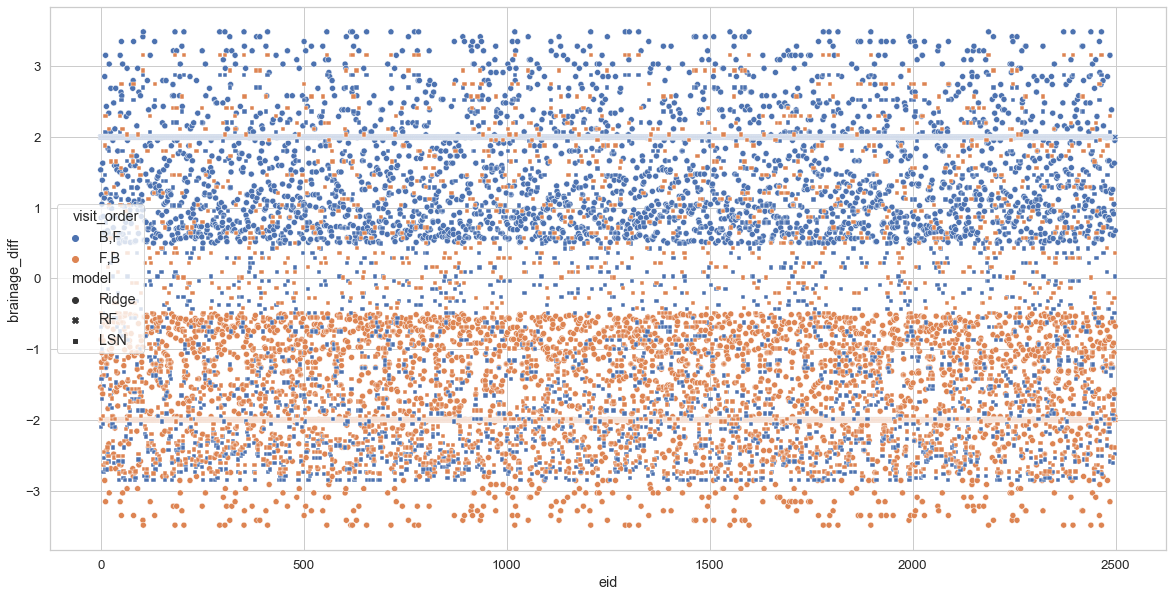

In [7]:
plot_df = perf_df.copy()
plot_df["brainage_diff"] = plot_df["test_brainage_2"] - plot_df["test_brainage_1"]
plot_df.loc[plot_df["visit_order"]=="F,B", "eid"] = plot_df[plot_df["visit_order"]=="F,B"]["eid"] - len(y_test)/2
# plot_df.loc[plot_df["visit_order"]=="B,B", "eid"] = plot_df[plot_df["visit_order"]=="B,B"]["eid"] - len(y_test)/2
# plot_df.loc[plot_df["visit_order"]=="F,F", "eid"] = plot_df[plot_df["visit_order"]=="F,F"]["eid"] - 3*len(y_test)/4

# plot_df = plot_df[plot_df["model"].isin(["Ridge","RF"])]
sns.set(font_scale=1.2)

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(20,10))
    g = sns.scatterplot(x="eid",y="brainage_diff",hue="visit_order", style="model", data=plot_df, ax=ax)


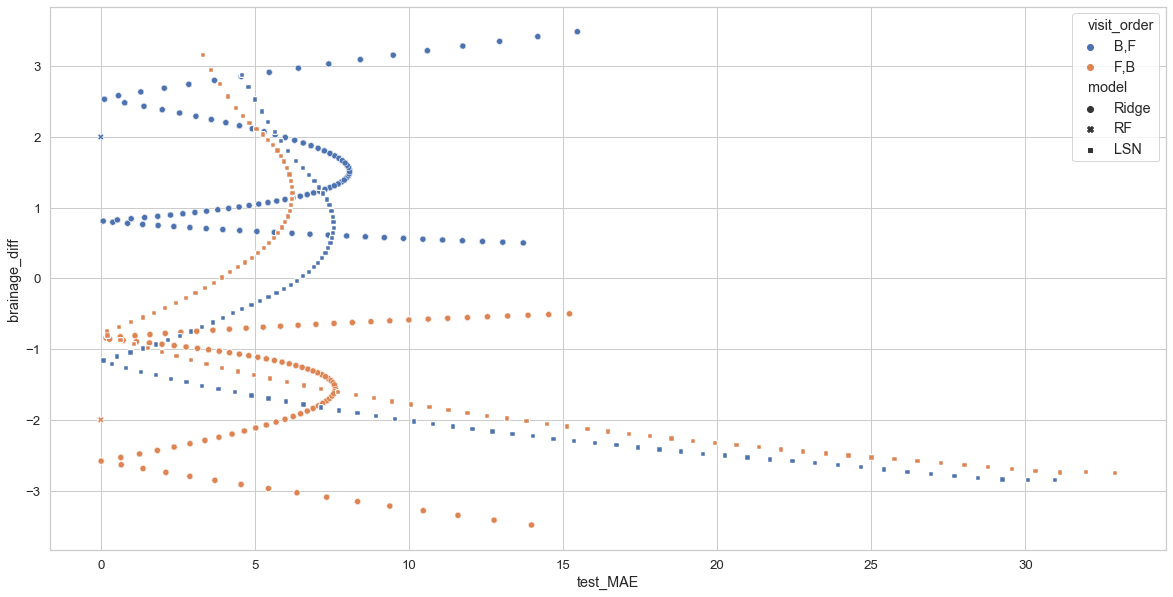

In [8]:
plot_df = perf_df.copy()
plot_df["brainage_diff"] = plot_df["test_brainage_2"] - plot_df["test_brainage_1"]
plot_df.loc[plot_df["visit_order"]=="F,B", "eid"] = plot_df[plot_df["visit_order"]=="F,B"]["eid"] - len(y_test)/2
# plot_df.loc[plot_df["visit_order"]=="B,B", "eid"] = plot_df[plot_df["visit_order"]=="B,B"]["eid"] - len(y_test)/2
# plot_df.loc[plot_df["visit_order"]=="F,F", "eid"] = plot_df[plot_df["visit_order"]=="F,F"]["eid"] - 3*len(y_test)/4

plot_df["test_MAE"] = 0.5 * (plot_df["test_MAE1"] + plot_df["test_MAE1"])
# plot_df = plot_df[plot_df["model"].isin(["Ridge","RF"])]

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(20,10))
    g = sns.scatterplot(x="test_MAE",y="brainage_diff",hue="visit_order", style="model", data=plot_df, ax=ax)

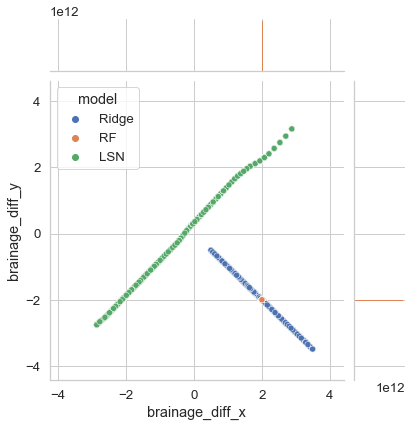

In [9]:
plot_df = perf_df.copy()
plot_df["brainage_diff"] = plot_df["test_brainage_2"] - plot_df["test_brainage_1"]

plot_df.loc[plot_df["visit_order"]=="F,B", "eid"] = plot_df[plot_df["visit_order"]=="F,B"]["eid"] - len(y_test)/2
# plot_df.loc[plot_df["visit_order"]=="B,B", "eid"] = plot_df[plot_df["visit_order"]=="B,B"]["eid"] - len(y_test)/2
# plot_df.loc[plot_df["visit_order"]=="F,F", "eid"] = plot_df[plot_df["visit_order"]=="F,F"]["eid"] - 3*len(y_test)/4

plot_df1 = plot_df[plot_df["visit_order"]=="B,F"][["eid","model","brainage_diff"]]
plot_df2 = plot_df[plot_df["visit_order"]=="F,B"][["eid","model","brainage_diff"]]
plot_df_long = pd.merge(plot_df1,plot_df2,on=["eid","model"])

# plot_df_long = plot_df_long[plot_df_long["model"].isin(["Ridge","RF"])]

with sns.axes_style("whitegrid"):
    g = sns.jointplot(x="brainage_diff_x", y="brainage_diff_y", hue="model", data=plot_df_long)